# Connect Eye-AI and Load Libraries

In [1]:
repo_dir = "Repos"   # Set this to be where your github repos are located.
%load_ext autoreload
%autoreload 2

# # Update the load path so python can find modules for the model
import sys
from pathlib import Path
sys.path.insert(0, str(Path.home() / repo_dir / "eye-ai-ml"))
sys.path.insert(0, str(Path.home() / repo_dir / "eye-ai-exec"))

In [2]:
# Prerequisites
import json
import os
import shutil
from PIL import Image

# EyeAI, Deriva, VGG19
from deriva_ml import DatasetSpec, DatasetBag, Workflow, ExecutionConfiguration, VersionPart
from deriva_ml import MLVocab as vc
from eye_ai.eye_ai import EyeAI

# ML Analytics
import pandas as pd
import numpy as np
import sklearn.metrics as sk

# Other Utilities
from pathlib import Path, PurePath
import logging
from datetime import datetime

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', force=True)

In [3]:
# Login
from deriva.core.utils.globus_auth_utils import GlobusNativeLogin
host = 'www.eye-ai.org'
#host = 'dev.eye-ai.org' #for dev testing
catalog_id = "eye-ai"

gnl = GlobusNativeLogin(host=host)
if gnl.is_logged_in([host]):
    print("You are already logged in.")
else:
    gnl.login([host], no_local_server=True, no_browser=True, refresh_tokens=True, update_bdbag_keychain=True)
    print("Login Successful")

2025-08-12 18:54:37,691 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-08-12 18:54:37,692 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>


You are already logged in.


# Configuration

In [4]:
cache_dir = '/data'
working_dir = '/data'
EA = EyeAI(hostname = host, catalog_id = catalog_id, cache_dir= cache_dir, working_dir=working_dir)

2025-08-12 18:54:40,824 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-08-12 18:54:40,825 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>


In [5]:


#ml_instance.increment_dataset_version(dataset_rid='2-N93J', component= VersionPart.patch, description='Update to latest deriva-ml schema')

In [6]:
datasets = [ '4-411G', '2-C9PR' ]#"2-39FY" ]

data_to_download = []
for dataset in datasets:
    ds_dict = {
        'rid': dataset,
        'materialize':False,
        'version':EA.dataset_version(dataset_rid=dataset),
    }
    data_to_download.append(ds_dict)

dataset_workflow = EA.add_workflow( 
    Workflow(
        name="Make Dataset by KB",
        url="https://github.com/informatics-isi-edu/eye-ai-exec/blob/main/notebooks/Sandbox_KB/Make_Dataset.ipynb",
        workflow_type="Test Workflow",
        )
    )

config = ExecutionConfiguration(
    datasets=data_to_download,
    workflow=dataset_workflow,
    description="Test"
    )

execution = EA.create_execution(config)

2025-08-12 18:54:44,579 - INFO - Materialize bag 4-411G... 
2025-08-12 18:54:44,777 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-08-12 18:54:44,778 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>
2025-08-12 18:54:46,301 - INFO - Using cached bag for  4-411G Version:2.7.0
2025-08-12 18:54:46,302 - INFO - Loading /data/4-411G_37ce9366c961c832931248ef462255860bc8595e0165040faa43113eba38ce45/Dataset_4-411G
2025-08-12 18:54:47,100 - INFO - Creating new database for dataset: 4-411G in /data/kb_766/EyeAI_working/4-411G@33N-3CNE-1XFP.db
2025-08-12 18:54:47,101 - INFO - Materialize bag 2-C9PR... 
2025-08-12 18:54:47,206 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-08-12 18:54:47,207 - INFO - Finished ini

In [7]:
print(execution)

caching_dir: /data
_working_dir: /data/kb_766/EyeAI_working
execution_rid: 5-4WYE
workflow_rid: 4-Z5Y4
asset_paths: {}
configuration: datasets=[DatasetSpec(rid='4-411G', materialize=False, version=DatasetVersion(major=2, minor=7, patch=0)), DatasetSpec(rid='2-C9PR', materialize=False, version=DatasetVersion(major=2, minor=7, patch=0))] assets=[] workflow='4-Z5Y4' parameters={} description='Test' argv=['/home/kb_766/.conda/envs/my-tensorflow-conda/lib/python3.10/site-packages/ipykernel_launcher.py', '-f', '/home/kb_766/.local/share/jupyter/runtime/kernel-2f5e238d-101c-4d36-b517-990edcf7b75a.json']


# Work with Data

In [8]:
ds_img = execution.datasets[0]
ds_test = execution.datasets[1]

In [30]:

disc_grades = pd.read_csv('Multimodal test set grading - disc only - KB 8-12-25.csv')
disc_grades = disc_grades.drop(['Random_Ind','Comments'], axis=1)
disc_grades = disc_grades.dropna(subset=['Glaucoma','GS+Mild_Mod+Severe'])

In [34]:
mergeDF = pd.merge( disc_grades[['RID_Subject', 'Eye', 'Glaucoma']],
         ds_img.get_table_as_dataframe('Execution_Subject_Chart_Label')[['Subject', 'Image_Side', 'Condition_Label']],
         left_on = ['RID_Subject', 'Eye'], right_on = ['Subject', 'Image_Side'],
         how = 'left'
        )[['RID_Subject', 'Eye', 'Glaucoma', 'Condition_Label']]

mergeDF = pd.merge( mergeDF,
         EA.multimodal_wide(ds_test)[['RID_Subject', 'Image_Side', 'MD']],
         left_on = ['RID_Subject', 'Eye'], right_on = ['RID_Subject', 'Image_Side'],
         how = 'left'
        )[['RID_Subject', 'Eye', 'Glaucoma', 'Condition_Label', 'MD']]

mergeDF['Binary_Grade'] = mergeDF['Glaucoma'].map({'0-suspect': 0, '1-glaucoma': 1})
mergeDF['Binary_Label'] = mergeDF['Condition_Label'].map({'GS': 0, 'POAG': 1, 'PACG': 1})


/home/kb_766/Repos/eye-ai-ml/eye_ai/eye_ai.py:423: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hvf_clean.loc[:, 'priority'] = hvf_clean['Field_Size'].map(priority)


In [35]:
mergeDF

,RID_Subject,Eye,Glaucoma,Condition_Label,MD,Binary_Grade,Binary_Label
0,2-7NVC,Right,0-suspect,GS,-2.55,0,0
1,2-7NWP,Right,0-suspect,GS,-2.89,0,0
2,2-7NQG,Right,1-glaucoma,POAG,-1.59,1,1
3,2-7N6W,Right,1-glaucoma,POAG,-4.68,1,1
4,2-7P0T,Left,1-glaucoma,GS,1.3,1,0
...,...,...,...,...,...,...,...
112,2-7P12,Right,0-suspect,POAG,-6.23,0,1
113,2-7P04,Left,0-suspect,GS,-1.64,0,0
114,2-7NXW,Right,0-suspect,POAG,-13.91,0,1
115,2-7NXW,Left,0-suspect,POAG,-2.48,0,1


Accuracy   : 0.675
Sensitivity: 0.556
Specificity: 0.815


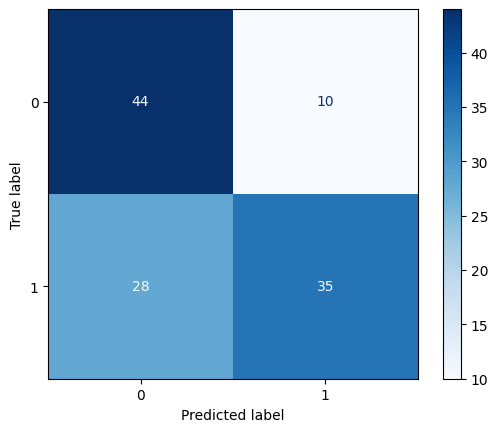

In [47]:
y_true = mergeDF['Binary_Label']
y_pred = mergeDF['Binary_Grade']
cm = sk.confusion_matrix(y_true, y_pred)

tn, fp, fn, tp = cm.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)       # Recall, True Positive Rate
specificity = tn / (tn + fp)       # True Negative Rate

sk.ConfusionMatrixDisplay(cm).plot(cmap='Blues')

print(f"Accuracy   : {accuracy:.3f}")
print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")

Accuracy   : 0.940
Sensitivity: 0.684
Specificity: 0.990


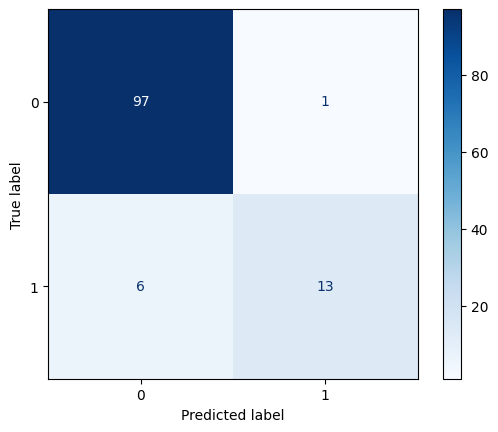

In [46]:
y_true = (mergeDF['Binary_Label'] == 1) & (mergeDF['MD'] < -6)
y_pred = (mergeDF['Binary_Grade'] == 1)  & (mergeDF['MD'] < -6)
cm = sk.confusion_matrix(y_true, y_pred)

tn, fp, fn, tp = cm.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)       # Recall, True Positive Rate
specificity = tn / (tn + fp)       # True Negative Rate

sk.ConfusionMatrixDisplay(cm).plot(cmap='Blues')

print(f"Accuracy   : {accuracy:.3f}")
print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")

In [ ]:
# Buffer